### Step 1: Cleaning and Preparing Data

In [4]:
"""
This notebook trains and evaluates classification models used
to predict sentiment values of tweets.
"""


# import packages
import pandas as pd
import numpy as np
import math
import string
import matplotlib.pyplot as plt
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, hamming_loss
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.sparse import csr_matrix
from typing import Any

import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/stlp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/stlp/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
# importing data
df = pd.read_csv("filtered_twitter_data(10,000).csv")

# excluding tweets with sentiment = 2 because 2 represents factual news about
# climate change, which is not a sentiment.
df = df[df['sentiment'] != 2]

df.head()

,sentiment,message,tweetid
0,0,RT @vincecable: Nice summary. Add climate chan...,955713180684177408
2,1,RT @leftcoastbabe: EPA Sec. #ScottPruitt says ...,839961977766178817
3,0,RT @jennyb81112: Not much global warming going...,954760066531495936
4,1,RT @PaulPolman: Increasingly companies have to...,953094505875562496
5,-1,RT @mitchellvii: Phoenix just broke a heat rec...,884035737687085056


In [6]:
# sentiment value counts
df.sentiment.value_counts()

sentiment
 1    5161
 0    1805
-1     885
Name: count, dtype: int64

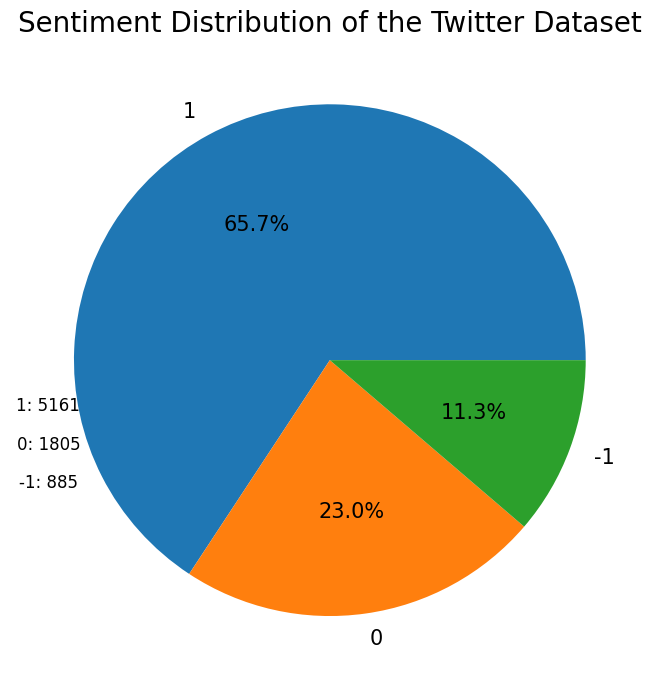

In [7]:
# shows the distribution of sentiment values for the twitter dataset
plt.figure(figsize=(7, 7))
value_counts = df.sentiment.value_counts()
plt.pie(value_counts.values,
        labels=value_counts.index,
        autopct='%2.1f%%',
        textprops={'fontsize': 15})
plt.title('Sentiment Distribution of the Twitter Dataset', fontsize=20)
plt.tight_layout()

# Display value counts as text
for i, count in enumerate(value_counts.values):
    plt.text(-1.1, -0.2 - i * 0.15,
             f"{value_counts.index[i]}: {count}",
             fontsize=12,
             ha='center')

plt.show()


In [8]:
def preprocessing_tweet(tweet: str) -> str:
    """
    Preprocesses a tweet by removing punctuation, usernames, and URLs.
    All words are lowercased.
    """
    stop_words = set(stopwords.words('english'))
    tweet_words = []
    for word in tweet.split(" "):
        # replaces usernames with @user
        if word.startswith("@") and len(word) > 1:
            word = "@user"
        # replaces URLs with http
        elif word.startswith("http"):
            word = "http"
        # Removes punctuation
        word = word.translate(str.maketrans('', '', string.punctuation))
        tweet_words.append(word.lower())
    tweet_proc = " ".join(tweet_words)
    text_tokens = word_tokenize(tweet_proc)
    filtered_text = [w for w in text_tokens if w not in stop_words]
    tweet = " ".join(filtered_text)
    return tweet


df['message'] = df['message'].apply(preprocessing_tweet)
df['message'].head()

0    rt user nice summary add climate change turnin...
2    rt user epa sec scottpruitt says co2 doesnt ca...
3         rt user much global warming going texas http
4    rt user increasingly companies deal fallout cl...
5    rt user phoenix broke heat record set 1905 omg...
Name: message, dtype: object

In [9]:
# defines the stemmer
stemmer = SnowballStemmer(language='english')


def stemming(tweet: str) -> str:
    """
    Removes suffixes from the given tweet.
    """
    tweet_words = []
    for word in tweet.split(" "):
        word = stemmer.stem(word)
        tweet_words.append(word)
    stem_tweet = " ".join(tweet_words)
    return stem_tweet


df['message'] = df['message'].apply(stemming)
df['message'].head()

0    rt user nice summari add climat chang turn pre...
2    rt user epa sec scottpruitt say co2 doesnt cau...
3                rt user much global warm go texa http
4    rt user increas compani deal fallout climat ch...
5    rt user phoenix broke heat record set 1905 omg...
Name: message, dtype: object

### Step 2: Training Models

In [10]:
# defines the label and the feature
X = list(df['message'])
y = list(df['sentiment'])


In [11]:
def splitting_data(X: list, y: list, n: int) -> tuple[csr_matrix,
                                                      csr_matrix,
                                                      np.ndarray,
                                                      np.ndarray,
                                                      TfidfVectorizer]:
    """
    Splits the data into training and testing sets, performs TF-IDF
    vectorization, and converts labels to binary vectors.
    """
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.20,
                                                        random_state=n,
                                                        stratify=y)

    # defines TF-IDF vectorizer and vectorizes testing and training data.
    vectorizer = TfidfVectorizer()
    vectorized_train_documents = vectorizer.fit_transform(X_train)
    vectorized_test_documents = vectorizer.transform(X_test)

    # using the One vs All concept to change the labels to vectors (3 x 1) each
    mlb = MultiLabelBinarizer()
    train_labels = mlb.fit_transform(map(str, y_train))
    test_labels = mlb.transform(map(str, y_test))

    return vectorized_test_documents, vectorized_train_documents, \
        train_labels, test_labels, vectorizer


In [12]:
# defines vectorized data, labels, and vectorizer
vectorized_test_documents, vectorized_train_documents, \
    train_labels, test_labels, vectorizer = splitting_data(X, y, 42)

### Step 3: Evaluating Models

In [13]:
results = {}


def metrics_report(model_name: str,
                   test_labels: np.ndarray,
                   predictions: np.ndarray,
                   results: dict[str, dict[str, float]]) -> None:
    """
    Calculates and stores metrics for a given model.
    """
    macro_f1 = f1_score(test_labels, predictions, average='macro')
    micro_f1 = f1_score(test_labels, predictions, average='micro')
    hamLoss = hamming_loss(test_labels, predictions)
    results[model_name] = {
        'micro_f1': micro_f1,
        'macro_f1': macro_f1,
        'hamming_loss': hamLoss
    }


In [14]:
def model_and_predict(vectorized_train_documents: csr_matrix,
                      vectorized_test_documents: csr_matrix,
                      train_labels: np.ndarray,
                      test_labels: np.ndarray,
                      model_name: str,
                      results: dict) -> None:
    """
    Fits the model, makes predictions, and calculates evaluation metrics.
    The classification report is printed.
    """
    model_name.fit(vectorized_train_documents, train_labels)
    pred = model_name.predict(vectorized_test_documents)
    metrics_report(model_name, test_labels, pred, results)

    # Print classification report
    print(f"Classification Report - {model_name.__class__.__name__}:")
    print(classification_report(test_labels, pred))


In [15]:
# testing with three different models
model_and_predict(vectorized_train_documents, vectorized_test_documents,
                  train_labels, test_labels,
                  DecisionTreeClassifier(), results)
model_and_predict(vectorized_train_documents, vectorized_test_documents,
                  train_labels, test_labels,
                  OneVsRestClassifier(LinearSVC()), results)
model_and_predict(vectorized_train_documents, vectorized_test_documents,
                  train_labels, test_labels,
                  RandomForestClassifier(), results)

Classification Report - DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.33      0.27      0.29       177
           1       0.41      0.39      0.40       361
           2       0.82      0.83      0.83      1210

   micro avg       0.70      0.68      0.69      1748
   macro avg       0.52      0.50      0.51      1748
weighted avg       0.69      0.68      0.68      1748
 samples avg       0.71      0.70      0.70      1748

Classification Report - OneVsRestClassifier:
              precision    recall  f1-score   support

           0       0.68      0.38      0.49       177
           1       0.60      0.43      0.50       361
           2       0.84      0.91      0.88      1210

   micro avg       0.79      0.76      0.78      1748
   macro avg       0.71      0.58      0.62      1748
weighted avg       0.78      0.76      0.76      1748
 samples avg       0.80      0.78      0.78      1748

Classification Report - RandomForestC

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
# the micro f1 score, macro f1 score, and hammingloss of the three models
results

{DecisionTreeClassifier(): {'micro_f1': 0.689575512561363,
  'macro_f1': 0.5060708298331762,
  'hamming_loss': 0.22809251007850626},
 OneVsRestClassifier(estimator=LinearSVC()): {'micro_f1': 0.7768353319684118,
  'macro_f1': 0.6222686105723321,
  'hamming_loss': 0.16189263738595375},
 RandomForestClassifier(): {'micro_f1': 0.7639304973037747,
  'macro_f1': 0.46758736126320793,
  'hamming_loss': 0.16719711436452367}}

Model LinearSVC performs the best as it has the highest values for micro f1
and macro f1 and the lowest value for hamming loss.

### Step 4: Evaluating Model Consistencies and Testing Data Processing

In [17]:


def test_model_consistency(models: dict,
                           X: np.ndarray,
                           y: np.ndarray,
                           num_iterations: int) -> dict:
    """
    Tests the consistency of multiple models with the given features, labels,
    and number of iterations.
    Returns the averaged micro f1 score, macro f1 score, and hammingloss of
    each model.
    """
    results = {}
    micro_f1_list = []
    macro_f1_list = []
    hamming_loss_list = []
    for i in range(num_iterations):
        vectorized_test_documents, vectorized_train_documents, \
            train_labels, test_labels, vectorizer = splitting_data(X, y, i)
        for model_name, model in models.items():
            model.fit(vectorized_train_documents, train_labels)
            pred = model.predict(vectorized_test_documents)
            metrics_report(model_name, test_labels, pred, results)
            micro_f1, macro_f1, hamLoss = results[model_name]['micro_f1'], \
                results[model_name]['macro_f1'], \
                results[model_name]['hamming_loss']
            micro_f1_list.append(micro_f1)
            macro_f1_list.append(macro_f1)
            hamming_loss_list.append(hamLoss)

    avg_micro_f1 = sum(micro_f1_list) / len(micro_f1_list)
    avg_macro_f1 = sum(macro_f1_list) / len(macro_f1_list)
    avg_hamming_loss = sum(hamming_loss_list) / len(hamming_loss_list)

    results[model_name] = {
        'micro_f1': avg_micro_f1,
        'macro_f1': avg_macro_f1,
        'hamming_loss': avg_hamming_loss
    }

    return results


In [18]:
# defines the model that we are testing
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'One-vs-Rest Linear SVC': OneVsRestClassifier(LinearSVC()),
    'Random Forest': RandomForestClassifier()
}

num_iterations = 10

consistency_results = test_model_consistency(models, X, y, num_iterations)

consistency_results

{'Decision Tree': {'micro_f1': 0.7007256894049347,
  'macro_f1': 0.5143163218276744,
  'hamming_loss': 0.21875663059622322},
 'One-vs-Rest Linear SVC': {'micro_f1': 0.757727406535178,
  'macro_f1': 0.570834245036687,
  'hamming_loss': 0.17462338213452153},
 'Random Forest': {'micro_f1': 0.7432059436651901,
  'macro_f1': 0.5242099490010363,
  'hamming_loss': 0.18511917391611848}}

This confirms that LinearSVC performs the best out of the three models as it
still has the highest average values for micro f1 and macro f1 and the
lowest average value for hamming loss after 10 iterations.

In [19]:
TOLERANCE = 0.001


def check_approx_equals(expected: Any, received: Any) -> bool:
    """
    Checks received against expected, and returns whether or
    not they match (True if they do, False otherwise).
    If the argument is a float, will do an approximate check.
    If the arugment is a data structure will do an approximate check
    on all of its contents.
    """
    try:
        if type(expected) == dict:
            # first check that keys match, then check that the
            # values approximately match
            return expected.keys() == received.keys() and \
                all([check_approx_equals(expected[k], received[k])
                    for k in expected.keys()])
        elif type(expected) == list or type(expected) == set:
            # Checks both lists/sets contain the same values
            return len(expected) == len(received) and \
                all([check_approx_equals(v1, v2)
                     for v1, v2 in zip(expected, received)])
        elif type(expected) == float:
            return math.isclose(expected, received, abs_tol=TOLERANCE)
        elif type(expected) == np.ndarray:
            return np.allclose(expected, received, atol=TOLERANCE,
                               equal_nan=True)
        elif type(expected) == pd.DataFrame:
            try:
                pd.testing.assert_frame_equal(expected, received,
                                              atol=TOLERANCE)
                return True
            except AssertionError:
                return False
        elif type(expected) == pd.Series:
            try:
                pd.testing.assert_series_equal(expected, received,
                                               atol=TOLERANCE)
                return True
            except AssertionError:
                return False
        else:
            return expected == received
    except Exception as e:
        print(f"EXCEPTION: Raised when checking check_approx_equals {e}")
        return False


In [20]:
def assert_equals(expected: Any, received: Any) -> None:
    """
    Checks received against expected, throws an AssertionError
    if they don't match. If the argument is a float, will do an approximate
    check. If the arugment is a data structure will do an approximate check
    on all of its contents.
    """
    if type(expected) == str:
        # Make sure strings have explicit quotes around them
        err_msg = f'Failed: Expected "{expected}", but received "{received}"'
    elif type(expected) in [np.ndarray, pd.Series, pd.DataFrame]:
        # Want to make multi-line output for data structures
        err_msg = f'Failed: Expected\n{expected}\n\nbut received\n{received}'
    else:
        err_msg = f'Failed: Expected {expected}, but received {received}'

    assert check_approx_equals(expected, received), err_msg


In [21]:
def test_preprocessing_tweet():
    """
    Tests function preprocessing_tweet
    """
    test_df = pd.read_csv("test.csv")

    # Define expected outputs
    expected_outputs = [
        "user uw students enrolled cse 163 intermediate python class \
enhance programming skills broaden understanding language info class http",
        "love u user"
    ]

    # Apply preprocessing_tweet function to 'message' column
    processed_messages = test_df['message'].apply(preprocessing_tweet)

    # Check if processed messages match the expected outputs
    for i, processed_message in enumerate(processed_messages):
        expected_output = expected_outputs[i]
        assert_equals(expected_output, processed_message)


test_preprocessing_tweet()


In [22]:
def test_stemming():
    """
    Tests function stemming
    """
    test_df = pd.read_csv("preprocessed_test.csv")

    # Define expected outputs
    expected_outputs = [
        "@ user uw student enrol cse 163 , intermedi python class , enhanc \
program skill broaden understand languag . info class http",
        "love u @ user"
    ]

    # Apply stemming function to 'message' column
    stemmed_messages = test_df['message'].apply(stemming)

    # Check if stemmed messages match the expected outputs
    for i, stemmed_message in enumerate(stemmed_messages):
        expected_output = expected_outputs[i]
        assert_equals(expected_output, stemmed_message)


In [23]:
# Run the test
test_stemming()

### Step 5: Calculating Feature Importance by Using TF-IDF Scores

In [24]:
# Initializing Vectorization of data
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(X)

# Retrieve feature names
feature_names = vectorizer.get_feature_names_out()

# Find the maximum TF-IDF scores for each feature
max_tfidf_scores = tfidf_matrix.max(axis=0).toarray()[0]

# Sort the maximum TF-IDF scores and retrieve the indices of the top 10 scores
top_indices = max_tfidf_scores.argsort()[-30:][::-1]

# Retrieve the corresponding feature names (words)
top_words = [feature_names[idx] for idx in top_indices]

# Print the top words with their TF-IDF scores
for word, score in zip(top_words, max_tfidf_scores[top_indices]):
    print(f"Word: {word}, TF-IDF Score: {score}")

Word: http, TF-IDF Score: 1.0
Word: ding, TF-IDF Score: 0.9980776379413474
Word: yada, TF-IDF Score: 0.9947324846219204
Word: user, TF-IDF Score: 0.9894859807702288
Word: ðÿ, TF-IDF Score: 0.9865824237740625
Word: proudcanadian, TF-IDF Score: 0.9830876493365694
Word: climatechangeakaweath, TF-IDF Score: 0.9830876493365694
Word: の危機, TF-IDF Score: 0.9830876493365694
Word: cowpocalyps, TF-IDF Score: 0.9830876493365694
Word: landyacht, TF-IDF Score: 0.9830876493365694
Word: nomine, TF-IDF Score: 0.9775836073657944
Word: fantast, TF-IDF Score: 0.9775836073657944
Word: silli, TF-IDF Score: 0.9714002729121064
Word: muh, TF-IDF Score: 0.9708888026646051
Word: hum, TF-IDF Score: 0.9708888026646051
Word: cop21, TF-IDF Score: 0.9687606264549361
Word: queen, TF-IDF Score: 0.964511396239041
Word: grammar, TF-IDF Score: 0.964254059852893
Word: jaichandramesh, TF-IDF Score: 0.9611697783856283
Word: found, TF-IDF Score: 0.9581057372702703
Word: globalist, TF-IDF Score: 0.954690547857873
Word: though,